In [1]:
import csv
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [2]:
def read_file(year):
    d = []
    filename = "deaths{}.csv".format(year)
    with open(filename, 'r') as f:
        r = csv.reader(f)
        for row in r:
            if row[0]=='Name': continue
            name = row[0]
            birth = date.fromisoformat(row[1])
            death = date.fromisoformat(row[2])
            covid = (row[3] == 'True')
            created = date.fromisoformat(row[4])
            if death < date(year,1,1) or death >=date(year+1,1,1):
                print ("Page {} weird death date {}".format(name, death))
                continue
            if created >= date(year,1,1):
                #print ("Page {} created too late: {}".format(name, death))
                continue
            d.append([name,birth,death,covid,created])
    return d

In [3]:
d2020 = read_file(2020)

Page Lawrence Bittaker and Roy Norris weird death date 2019-12-13
Page Kiing Shooter weird death date 2019-12-20
Page Stanislav Libenský and Jaroslava Brychtová weird death date 2002-02-24
Page Del Martin and Phyllis Lyon weird death date 2008-08-27
Page Ty (rapper) weird death date 2003-10-11


In [4]:
def hist_death(data, start_day, end_day=None, filt=None):
    if not filt: filt = lambda _: True
    if not end_day: end_day = date(start_day.year+1,1,1)
    num_days = (end_day-start_day).days
    dates = [start_day+timedelta(days=j) for j in range(num_days)]
    count = np.zeros(num_days)
    for row in data:
        if not filt(row):
            continue
        j=(row[2]-start_day).days
        if j<0 or j>=num_days:
            continue
        count[j]+=1
    return dates, count

In [5]:
end_day = max(row[2] for row in d2020) + timedelta(days=1)
start_day = date(2020,1,1)
dates, count_all = hist_death(d2020, start_day, end_day)
_, count_cvd = hist_death(d2020, start_day, end_day, lambda row: row[3])
_, count_base = hist_death(d2020, start_day, end_day, lambda row: not row[3])

In [6]:
def ma(x, win=7):
    w = np.ones(win)/win
    return np.convolve(x, w, 'valid')
ma_all = ma(count_all)
ma_cvd = ma(count_cvd)
ma_base = ma(count_base)

In [7]:
d2019 = read_file(2019)

Page Ahmad Shah of Pahang weird death date 1932-06-23
Page Dixie Allen weird death date 2006-07-27
Page Claire Ball weird death date 1982-12-31
Page Bettina F. Bradbury weird death date 2006-01-20
Page Russ Cochran (publisher) weird death date 2020-02-23
Page Hein & Oss weird death date 2016-02-14
Page Susan Irvine weird death date 2013-08-05
Page Sushil Kumar (admiral) weird death date 2001-12-29
Page Ehsan-ul-Haq Piracha weird death date 1990-12-06
Page Keith Robbins weird death date 2001-08-31
Page Augie and Margo Rodriguez weird death date 2014-07-18
Page Hogan Sheffer weird death date 2006-08-09
Page Peter Smedley weird death date 2011-04-11
Page Sam Szafran weird death date 2011-01-30
Page Brian Tarantina weird death date 1980-03-30
Page Marv Terhoch weird death date 1981-05-31
Page Ed and Lorraine Warren weird death date 2006-08-23


In [8]:
dates2019, count2019 = hist_death(d2019, date(2019,1,1))
ma2019 = ma(count2019)

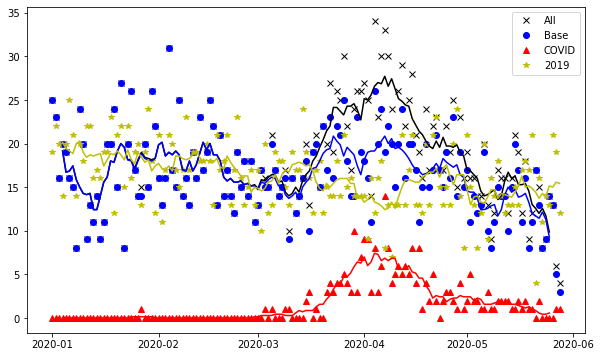

In [9]:
plt.figure(figsize=(10,6))
plt.plot_date(dates, count_all, 'kx')
plt.plot_date(dates, count_base, 'bo')
plt.plot_date(dates, count_cvd, 'r^')
plt.plot_date(dates, count2019[:len(dates)], 'y*')
plt.plot_date(dates[3:-3], ma_all, 'k-')
plt.plot_date(dates[3:-3], ma_base, 'b-')
plt.plot_date(dates[3:-3], ma_cvd, 'r-')
plt.plot_date(dates[3:], ma2019[:len(dates)-3], 'y-')
plt.legend(['All', 'Base', 'COVID', '2019'])

In [10]:
np.sum(count_cvd)/np.sum(count_all)

0.08916019237883832

In [11]:
ages = [(row[2] - row[1])/timedelta(days=365.25) for row in d2020]
ages_cvd = [(row[2] - row[1])/timedelta(days=365.25) for row in d2020 if row[3]]

(array([ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  3.,  0.,  5.,  9., 16.,
        15., 28., 37., 44., 42., 25., 11.,  2.,  1.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110.]),
 <a list of 22 Patch objects>)

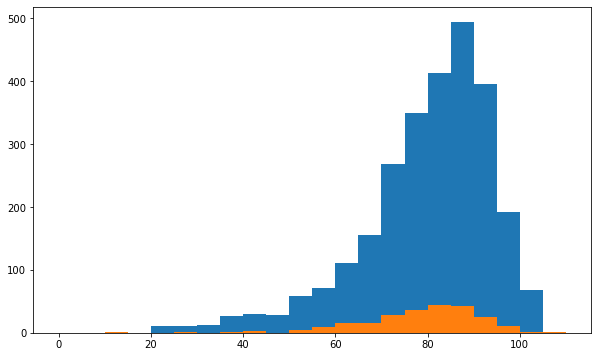

In [12]:
plt.figure(figsize=(10,6))
plt.hist(ages, bins=22, range=(0,110))
plt.hist(ages_cvd, bins=22, range=(0,110))

In [13]:
np.median(ages), np.median(ages_cvd), np.average(ages), np.average(ages_cvd)

(82.98973305954826, 80.85968514715948, 79.9024391232091, 78.61160292075284)

In [14]:
d2018 = read_file(2018)
dates2018, count2018 = hist_death(d2018, date(2018,1,1))
d2017 = read_file(2017)
dates2017, count2017 = hist_death(d2017, date(2017,1,1))

Page Dugan Aguilar weird death date 2008-01-27
Page Maxine Asher weird death date 2015-03-19
Page Rahim Uddin Bharosha weird death date 2020-03-11
Page Bernard Bragg weird death date 2019-10-29
Page Pearl Carr & Teddy Johnson weird death date 2020-02-16
Page Edoardo Catellani weird death date 2019-07-10
Page Valentin Chaikin weird death date 1955-01-10
Page Rodolfo de la Garza weird death date 2019-08-05
Page Christa Dichgans weird death date 1997-02-26
Page Marianne Eigenheer weird death date 2012-02-11
Page Caroline Hebbe weird death date 1959-01-18
Page Henrik, Prince Consort of Denmark weird death date 1967-06-10
Page Hans Joachim Keil III weird death date 2019-08-31
Page Oleg Lobov weird death date 1991-11-06
Page George Mastics weird death date 1974-12-31
Page Margo McCaffery weird death date 2008-01-09
Page Özden Örnek weird death date 2005-08-26
Page Alice and Martin Provensen weird death date 1987-03-27
Page Mete Sozen weird death date 2008-04-05
Page Ian Spry weird death date

In [15]:
c2020 = np.cumsum(count_all)
c2019 = np.cumsum(count2019)
c2018 = np.cumsum(count2018)
c2017 = np.cumsum(count2017)
print(c2017[-1], c2018[-1], c2019[-1], c2020[-1])

5295.0 5413.0 5514.0 2703.0


In [16]:
wp_size = np.array([5321200, 5541900, 5773600, 5989400])
weight = wp_size[-1]/wp_size
print(weight)
cs2017, cs2018, cs2019, cs2020 = c2017*weight[0], c2018*weight[1], c2019*weight[2], c2020*weight[3]

[1.12557318 1.08074848 1.03737703 1.        ]


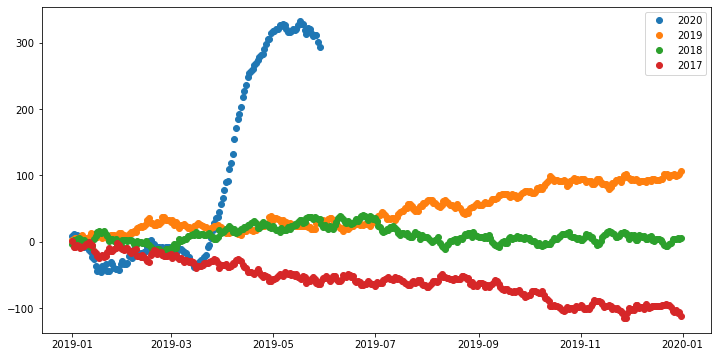

In [17]:
plt.figure(figsize=(12,6))
cavg = (c2019+c2018+c2017)/3.0
plt.plot_date(dates2019[:len(c2020)], c2020-cavg[:len(c2020)])
plt.plot_date(dates2019, c2019-cavg)
plt.plot_date(dates2019, c2018-cavg)
plt.plot_date(dates2019, c2017-cavg)
plt.legend(['2020', '2019', '2018', '2017'])

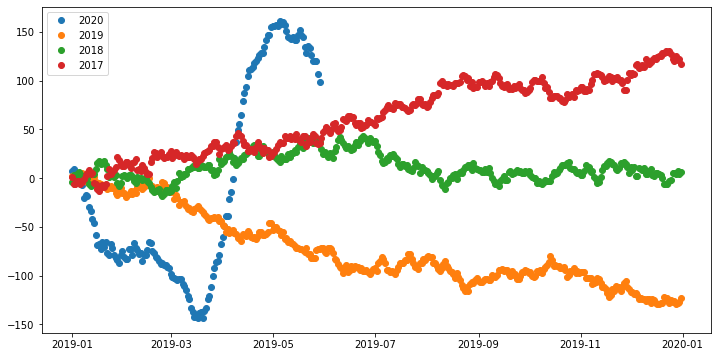

In [18]:
plt.figure(figsize=(12,6))
csavg = (cs2019+cs2018+cs2017)/3.0
plt.plot_date(dates2019[:len(c2020)], cs2020-csavg[:len(c2020)])
plt.plot_date(dates2019, cs2019-csavg)
plt.plot_date(dates2019, cs2018-csavg)
plt.plot_date(dates2019, cs2017-csavg)
plt.legend(['2020', '2019', '2018', '2017'])